# Reading 1D ecRad Output File. IWP Analysis. LogScale Figures with LogScale Colorbars

Version 6: 2024-05-16

Fixed parameters:

1. Radiative Transfer Model: ecRad
2. Cosine of solar zenith angle: $\mu = 0.6$ (effective solar zenith angle of $53^{\circ}$, Wallace&Hobbs, 2006).
3. SW albedo: $\alpha = 0.05$ (Hartmann & Berry, 2017).
4. LW emissivity: $\epsilon = 0.97$ (REFERENCE?).
5. Skin temperature as surface temperature: $T_{skin} = 300 K$ (290 to 300 K (Jin & Dickinson, 2010)).
6. No gases and aerosols.
7. No liquid water.
8. Tropical Sounding Climatology (Temperature, Pressure and Specific Humidity) (Lapse Rate of $6.7\;K/km$ (see "1D_ecrad_input_creator_height_v6.ipynb")).

Variable parameters:
1. Macro: Temperature (Altitude-position) = 236 K, 218 K and 201 K for cloud middle level.
2. Macro: Geometrical Depth $\Delta h = 1.5 km$.
3. Macro: Ice Water Path (IWP) = 0.1:0.1:1000 $g/m^2$ (Sokol & Hartmann 2020):

    $$IWP \;=\; \int{IWC\;dz} \;=\; \int_{h_1}^{h_2}{q_i\;\rho(z)\;dz}\;\;\; , \;\;\;(h_2 - h_1 = 1.5 \;km)$$

    where IWC is the Ice Water Content $(g/m^3)$, which is the Ice Water Mixing Ratio $q_{i}\;(g/km)$ times the density $\rho(z)$:

    $$\Rightarrow\;q_i = \frac{IWP}{\int_{h_1}^{h_2}{\rho(z)\;dz}}$$

4. Micro: Effective Radius $r_e$ = 30 $\mu m$ (Hartmann & Berry, 2017).
5. Ice Optical Schemes:

    5.1 Fu 1996 and Fu, Yang & Sun 1998 (1O).
    
    5.2 Yi et al. 2013 (2O).
    
    5.3 Baran et al. 2016 (3O).
    
    5.4 Baran et al. 2014 (4O).
    
    
6. Solvers: Tripleclouds

## Loading Libraries

Version list:

1. xarray : 2022.11.0
2. numpy : 1.23.4
4. matplotlib : 3.6.2

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from scipy import interpolate
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib notebook

## Reading data

### ecRad output data

- 1O: Fu (Fu 1996 / Fu, Yang & Sun 1998)
- 2O: Yi (Yi et al. 2013)
- 3O: Baran2016 (Baran et al. 2016)
- 4O: Baran (Baran et al. 2014)

In [2]:
data_path = ('/groups/sylvia/ecrad_tests/ecrad_test_1/')
for pert in ['236','218','201']:
    for opt in range(1,5):
        file = 'output_1D_matrix_iwp_'+pert+'_'+str(opt)+'O1S_logscale_v6.nc'
        globals()['ecrad_out_'+pert+'_'+str(opt)+'O1S'] = xr.open_dataset(data_path+file)

### Tropical Profile

In [3]:
tropical_profile = pd.read_csv('/home/u5/edgardo/p01_crh_sensitivity/tropical_profile_ellingson_250m.txt',
                               sep='\s+ ')

/tmp/ipykernel_25196/1624852093.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tropical_profile = pd.read_csv('/home/u5/edgardo/p01_crh_sensitivity/tropical_profile_ellingson_250m.txt',


In [4]:
temp_int       = interpolate.interp1d(tropical_profile['pressure (hPa)'].iloc[::-1]*100,
                                      tropical_profile['temperature (K)'].iloc[::-1])
temperature_hl = temp_int(ecrad_out_236_1O1S.pressure_hl.values)

height_int     = interpolate.interp1d(tropical_profile['pressure (hPa)'].iloc[::-1]*100,
                                      tropical_profile['height (km)'].iloc[::-1])
height_hl      = height_int(ecrad_out_236_1O1S.pressure_hl.values)

In [5]:
temp            = pd.Series(temperature_hl[0])
tropopause_i    = temp.argmin()
upper_limit_i   = (temp.iloc[tropopause_i:] - 201).abs().argmin()
lower_limit_i   = (temp.iloc[tropopause_i:] - 236).abs().argmin()
temp_range      = temp.iloc[tropopause_i+upper_limit_i:tropopause_i+lower_limit_i+1]
melting_layer_i = (temp - 273.15).abs().argmin()
melting_layer   = temp.iloc[melting_layer_i]
tropopause      = temp.min()

height_hl_pd    = pd.Series(height_hl[0])

### Cloud-radiative Heating (CRH) Rate matrix calculation:

Cloud-radiative Heating (CRH) rate in $K\;d^{-1}$ for each spectral component $i$ (SW and LW):

$$CRH_{i} \;=\; - \frac{g_0}{C_P}\frac{\partial }{\partial P}(CRE_{i})\;\;\frac{K}{s}\times\;86400\;\frac{s}{d}$$

where $g_0$ is the standard gravity acceleration ($9.8\;ms^{-2}$), $C_P$ is the specific heat capacity of dry air ($1080\;J kg^{-1} K^{-1}$) and $CRE_{i}$ is the Cloud Radiative Effect for each spectral component $i$ (SW and LW), computed as:

$$CRE_{i} \;=\; F_{All_{i}}^{NET} - F_{Clear_{i}}^{NET}$$

where $F^{NET}$ is the NET irradiance or flux ($Wm^{-2}$), computed as:

$$F_{i}^{NET} \;=\; F_{i}^{Downward} - F_{i}^{Upward}$$

The sign in the CRH equation is because of the definition of the outgoing fluxes as positive ??

In [6]:
rows_iwp = ecrad_out_236_1O1S.sizes['column']     # IWP (0.1 - 200 g/m2 in logscale)
prof     = ecrad_out_236_1O1S.sizes['half_level'] # Vertical Profile

## Heat capacity [J kg^-1 K^-1]:
cp = 1.08*10**(3)
## Volumetric heat capacity as ICON evaluates on model levels, not pl:
# cv = 0.718*10**3
## Gravity [m s^-2]:
g = 9.8

for pert in ['236','218','201']:
    ## Heating rates matrices [K day-1]:
    globals()['H_lw_'+pert] = np.zeros((4, rows_iwp, prof))
    globals()['H_sw_'+pert] = np.zeros((4, rows_iwp, prof))
    globals()['H_net_'+pert]    = np.zeros((4, rows_iwp, prof))

    ## Matrices for plotting:
    globals()['H_sw_'+pert+'_plot'] = np.zeros((4, prof, rows_iwp))
    globals()['H_lw_'+pert+'_plot'] = np.zeros((4, prof, rows_iwp))
    globals()['H_net_'+pert+'_plot']    = np.zeros((4, prof, rows_iwp))

    for opt in range(1,5): # per optical scheme
        ecrad_out = eval('ecrad_out_'+pert+'_'+str(opt)+'O1S')
        for i in range(rows_iwp):
            pres = ecrad_out.pressure_hl.values[i] # Pressure [Pa]

            # Net Fluxes [W m-2]
            lw_net_flux_cloudy = ecrad_out.flux_dn_lw.values[i] - ecrad_out.flux_up_lw.values[i]
            lw_net_flux_clear  = ecrad_out.flux_dn_lw_clear.values[i] - ecrad_out.flux_up_lw_clear.values[i]
            sw_net_flux_cloudy = ecrad_out.flux_dn_sw.values[i] - ecrad_out.flux_up_sw.values[i]
            sw_net_flux_clear  = ecrad_out.flux_dn_sw_clear.values[i] - ecrad_out.flux_up_sw_clear.values[i]

            # Cloud Radiative Effect [W m-2]
            lw_cre = lw_net_flux_cloudy - lw_net_flux_clear
            sw_cre = sw_net_flux_cloudy - sw_net_flux_clear
            
            # The sign is because of the definition of Outgoing fluxes as positive:
            # By using the diff function:
            #H_lw[opt-1,i,:] = -(g/cp)*(np.diff(lw_cre)/np.diff(pres))*86400 # K day^(-1)
            #H_sw[opt-1,i,:] = -(g/cp)*(np.diff(sw_cre)/np.diff(pres))*86400 # K day^(-1)
            # By using the gradient function:
            eval('H_lw_'+pert)[opt-1,i,:] = -(g/cp)*(np.gradient(lw_cre, pres))*86400 # K day^(-1)
            eval('H_sw_'+pert)[opt-1,i,:] = -(g/cp)*(np.gradient(sw_cre, pres))*86400 # K day^(-1)

        eval('H_net_'+pert)[opt-1,:,:] = eval('H_lw_'+pert)[opt-1,:,:] + eval('H_sw_'+pert)[opt-1,:,:]

        # For plotting:
        eval('H_sw_'+pert+'_plot')[opt-1,:,:] = np.transpose(eval('H_sw_'+pert)[opt-1,:,:])
        eval('H_lw_'+pert+'_plot')[opt-1,:,:] = np.transpose(eval('H_lw_'+pert)[opt-1,:,:])
        eval('H_net_'+pert+'_plot')[opt-1,:,:]    = np.transpose(eval('H_net_'+pert)[opt-1,:,:])

#### Cloud Heating Rate (CRH) matrix for plotting (3 perturbations together):

In [7]:
rows_iwp

2000

In [8]:
## New Matrices for plotting:
H_sw_plot = np.zeros((4, prof, rows_iwp))
H_lw_plot = np.zeros((4, prof, rows_iwp))
H_net_plot = np.zeros((4, prof, rows_iwp))

for pert in [236, 218, 201]:
    pert_i = (temp.iloc[tropopause_i:] - pert).abs().argmin() # iloc position
    i = tropopause_i + pert_i
#    if pert == 218: bottom_step = 5
#    else: bottom_step = 4
#     if pert == 236: top_step = 3
#     else: top_step = 4
    H_sw_plot[:,i-4:i+5,:] = eval('H_sw_'+str(pert)+'_plot')[:,i-4:i+5,:]
    H_lw_plot[:,i-4:i+5,:] = eval('H_lw_'+str(pert)+'_plot')[:,i-4:i+5,:]
    H_net_plot[:,i-4:i+5,:] = eval('H_net_'+str(pert)+'_plot')[:,i-4:i+5,:]

 ### CRH vs IWP for top and bottom layer

In [9]:
iwp = np.logspace(np.log10(.1),np.log10(200), 2000)

### Evaluating maximum values of CRH

In [10]:
print('LW Fu max: ',H_lw_plot[0,:,:].max())
print('LW Fu min: ',H_lw_plot[0,:,:].min())
print('LW Yi max: ',H_lw_plot[1,:,:].max())
print('LW Yi min: ',H_lw_plot[1,:,:].min())
print('LW Baran2016 max: ',H_lw_plot[2,:,:].max())
print('LW Baran2016 min: ',H_lw_plot[2,:,:].min())
print('LW Baran2014 max: ',H_lw_plot[3,:,:].max())
print('LW Baran2014 min: ',H_lw_plot[3,:,:].min())
print('')
print('SW Fu max: ',H_sw_plot[0,:,:].max())
print('SW Fu min: ',H_sw_plot[0,:,:].min())
print('SW Yi max: ',H_sw_plot[1,:,:].max())
print('SW Yi min: ',H_sw_plot[1,:,:].min())
print('SW Baran2016 max: ',H_sw_plot[2,:,:].max())
print('SW Baran2016 min: ',H_sw_plot[2,:,:].min())
print('SW Baran2014 max: ',H_sw_plot[3,:,:].max())
print('SW Baran2014 min: ',H_sw_plot[3,:,:].min())
print('')
print('Fu max: ',H_plot[0,:,:].max())
print('Fu min: ',H_plot[0,:,:].min())
print('Yi max: ',H_plot[1,:,:].max())
print('Yi min: ',H_plot[1,:,:].min())
print('Baran2016 max: ',H_plot[2,:,:].max())
print('Baran2016 min: ',H_plot[2,:,:].min())
print('Baran2014 max: ',H_plot[3,:,:].max())
print('Baran2014 min: ',H_plot[3,:,:].min())

LW Fu max:  104.83187475136052
LW Fu min:  -42.13767952110765
LW Yi max:  102.715882959933
LW Yi min:  -39.95851074580755
LW Baran2016 max:  117.12032611493207
LW Baran2016 min:  -52.46958883021922
LW Baran2014 max:  103.930313442843
LW Baran2014 min:  -40.90298874145276

SW Fu max:  48.93265321681944
SW Fu min:  -1.0437201285246833
SW Yi max:  43.37249361472877
SW Yi min:  -0.9854474828754136
SW Baran2016 max:  75.68372042079216
SW Baran2016 min:  -1.004986907248382
SW Baran2014 max:  63.98651646527645
SW Baran2014 min:  -1.04431303562014

Fu max:  110.98518950618049
Fu min:  -14.548435635278395
Yi max:  109.30741748075651
Yi min:  -15.716819102095553
Baran2016 max:  123.15833557365778
Baran2016 min:  -14.503066389891625
Baran2014 max:  111.88536536184348
Baran2014 min:  -10.237909432356822


### Plotting CRH Matrix

In [11]:
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

<IPython.core.display.Javascript object>


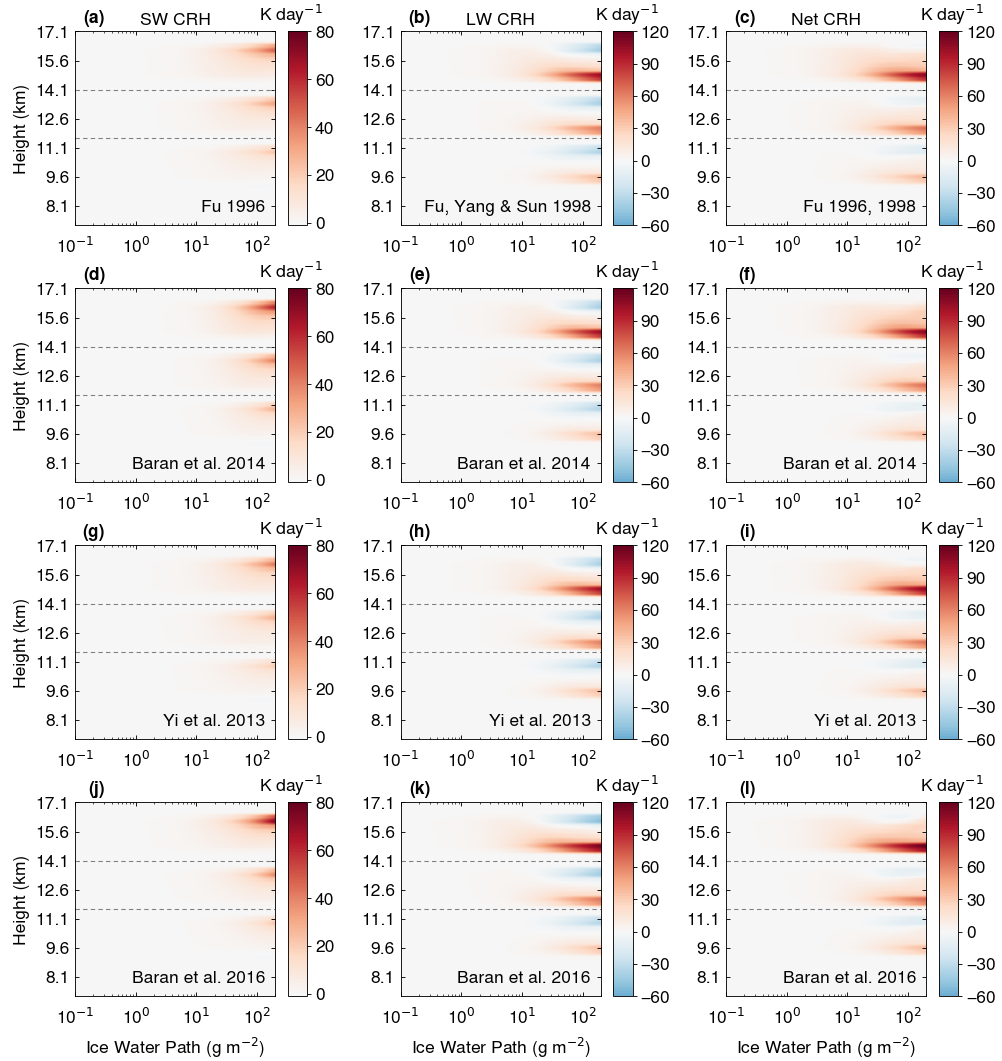

In [12]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 13.5 # inches
flength  = 12.75 # inches

rows    = 4
columns = 3
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.97, bottom = 0.06, left = 0.075, right = 0.975, 
                    hspace = .325, wspace = .3)

# COLORMAPS
vmini = -60
vmaxi = 120
tickbar = [vmini, -30, 0, 30, 60, 90, vmaxi]

#For shortwave:
vmini_sw = -1
vmaxi_sw = 80
tickbar_sw = [0, 20, 40, 60, vmaxi_sw]

Sch_order = [0, 3, 1, 2] # Fu, Baran 2014, Yi and Baran2016

for opt in range(rows):
    sch = Sch_order[opt]
    
    # Shortwave Heating Rate
    im = ax[opt, 0].imshow(H_sw_plot[sch], cmap = 'RdBu_r', aspect = 'auto',
                           norm = MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw)) 
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_sw)
    cbar.set_label(r'K day$^{-1}$', labelpad = -40, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if opt == 0:
        ax[opt, 0].set_title('SW CRH', color = 'black',
                             fontsize = fontsize, fontname = fontname)

    # Longwave Heating Rate
    im = ax[opt, 1].imshow(H_lw_plot[sch], cmap = 'RdBu_r', aspect = 'auto', 
                           norm = MidpointNormalize(midpoint = 0, vmin = vmini, vmax = vmaxi))
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar)
    cbar.set_label(r'K day$^{-1}$', labelpad = -40, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if opt == 0:
        ax[opt, 1].set_title('LW CRH', color = 'black',
                             fontsize = fontsize, fontname = fontname)

    # Heating Rate
    im = ax[opt, 2].imshow(H_plot[sch], cmap = 'RdBu_r', aspect = 'auto',
                           norm = MidpointNormalize(midpoint = 0, vmin = vmini, vmax = vmaxi))
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar)
    cbar.set_label(r'K day$^{-1}$', labelpad = -40, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if opt == 0:
        ax[opt, 2].set_title('Net CRH', color ='black',
                             fontsize = fontsize, fontname = fontname)
        
    ax[sch, 0].axhline((height_hl_pd - 11.5).abs().argmin(),
                       dashes=[4, 3], color = 'grey', linewidth = 1)
    ax[sch, 0].axhline((height_hl_pd - 14).abs().argmin(),
                       dashes=[4, 3], color = 'grey', linewidth = 1)
    ax[sch, 1].axhline((height_hl_pd - 11.5).abs().argmin(),
                       dashes=[4, 3], color = 'grey', linewidth = 1)
    ax[sch, 1].axhline((height_hl_pd - 14).abs().argmin(), 
                       dashes=[4, 3], color = 'grey', linewidth = 1)
    ax[sch, 2].axhline((height_hl_pd - 11.5).abs().argmin(),
                       dashes=[4, 3], color = 'grey', linewidth = 1)
    ax[sch, 2].axhline((height_hl_pd - 14).abs().argmin(), 
                       dashes=[4, 3], color = 'grey', linewidth = 1)

# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0, H_236.shape[2]+1, 6) # altitude tick labels
#yticks      = np.arange(0, H.shape[2]+1, 6) # altitude tick labels
yticklabels = height_hl_pd.loc[yticks].round(1).to_list()
#yticklabels = temp.loc[yticks].astype('int').to_list()  
    
# X Axis: # Logscale ticklabels are built manually:
major_xticklabels = np.logspace(np.log10(0.1), np.log10(100), 4)
minor_xticklabels = list(np.linspace(0.1, 1, 10))[:-1] + list(np.linspace(1, 10, 10))[:-1] + list(np.linspace(10, 100, 10)) + [200]
major_xticks      = []
minor_xticks      = []
for xticklabelsi in major_xticklabels:
    major_xticks.append(np.where(iwp == min(iwp, key = lambda x: abs(x - xticklabelsi)))[0][0])
for xticklabelsi in minor_xticklabels:
    minor_xticks.append(np.where(iwp == min(iwp, key = lambda x: abs(x - xticklabelsi)))[0][0])
    
OptSch_sw       = ['Fu 1996', 'Yi et al. 2013', 'Baran et al. 2016', 'Baran et al. 2014']
OptSch_lw       = ['Fu, Yang & Sun 1998', 'Yi et al. 2013', 'Baran et al. 2016', 'Baran et al. 2014']
OptSch          = ['Fu 1996, 1998', 'Yi et al. 2013', 'Baran et al. 2016', 'Baran et al. 2014']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)']
panel_letters_i = 0
for opt in range(rows): # Fu, Yi, Baran2016 and Baran 2014
    sch = Sch_order[opt]
    for j in range(columns):
        # Horizontal Lines:
        #h = ax[j,i].axhline(y = melting_layer_i, linestyle = 'dashed', color = 'grey',
        #                    dashes = (3, 2), linewidth  =2)
        #h = ax[j,i].axhline(y = tropopause_i, linestyle = 'dashed', color = 'grey',
        #                    dashes = (3, 2), linewidth  =2)
        if opt == 3:
            ax[opt, j].set_xlabel(r'Ice Water Path (g m$^{-2}$)', 
                                  fontsize = fontsize, fontname = fontname,
                                  color ='black', labelpad = 7.5)
        ax[opt, j].set_xticks(major_xticks)
        ax[opt, j].set_xticks(minor_xticks, minor = True)
        ax[opt, j].tick_params(axis = 'x', which = 'major', color = 'black',
                               size = 4, direction = 'in', top = True,
                               labelsize = fontsize, pad = 10)
        ax[opt, j].tick_params(axis = 'x', which = 'minor', color = 'black',
                               size = 2, direction = 'in', top = True,
                               labelsize = fontsize, pad = 10)
        for tick in ax[opt, j].get_xticklabels():
            tick.set_fontname(fontname)   
        #ax[diff, j].set_xticks(xticks)
        ax[opt, j].set_xticklabels(major_xticklabels)
        ax[opt, j].set_xticklabels([r'10$^{-1}$', r'10$^{0}$', r'10$^{1}$', r'10$^{2}$'])
        #ax[diff, j].set_xlim(0.1, 2000)
        #ax[diff, j].set_xscale('log')
        
        ax[opt, j].tick_params(axis = 'y', which = 'major', color = 'black',
                               size = 4, direction = 'in', right = True,
                               labelsize = fontsize, pad = 5)
        for tick in ax[opt, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[opt, j].set_yticks(yticks)
        ax[opt, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[opt, j].set_ylabel('Height (km)', fontsize = fontsize, fontname = fontname,
                                  color ='black', labelpad = 5)
            ax[opt, j].text(0.95, 0.05, OptSch_sw[sch],
                            ha = 'right', va = 'bottom', transform = ax[opt, j].transAxes,
                            fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 1:
            ax[opt, j].text(0.95, 0.05, OptSch_lw[sch],
                            ha = 'right', va = 'bottom', transform = ax[opt, j].transAxes,
                            fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 2:
            ax[opt, j].text(0.95, 0.05, OptSch[sch],
                            ha = 'right', va = 'bottom', transform = ax[opt, j].transAxes,
                            fontsize = fontsize, fontname = fontname, color = 'black')
        ax[opt, j].set_ylim((height_hl_pd - 7).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        
        # Panel letters:
        ax[opt, j].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
                        ha = 'right', va = 'top', transform = ax[opt, j].transAxes,
                        fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1
        
# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_matrix_iwp_1S_short_v6b_SM.png', dpi=500)

#### Plotting Differences Matrix

In [10]:
# Shortwave:
H_sw_diff_plot    = np.zeros((3, prof, rows_iwp))
H_sw_diff_plot[0] = H_sw_plot[1] - H_sw_plot[0] # Yi - Fu
H_sw_diff_plot[1] = H_sw_plot[2] - H_sw_plot[0] # Baran2016 - Fu
H_sw_diff_plot[2] = H_sw_plot[3] - H_sw_plot[0] # Baran2014 - Fu

# Longwave:
H_lw_diff_plot    = np.zeros((3, prof, rows_iwp))
H_lw_diff_plot[0] = H_lw_plot[1] - H_lw_plot[0] # Yi - Fu
H_lw_diff_plot[1] = H_lw_plot[2] - H_lw_plot[0] # Baran2016 - Fu
H_lw_diff_plot[2] = H_lw_plot[3] - H_lw_plot[0] # Baran2014 - Fu

# Net:
H_net_diff_plot    = np.zeros((3, prof, rows_iwp))
H_net_diff_plot[0] = H_net_plot[1] - H_net_plot[0] # Yi - Fu
H_net_diff_plot[1] = H_net_plot[2] - H_net_plot[0] # Baran - Fu
H_net_diff_plot[2] = H_net_plot[3] - H_net_plot[0] # Baran - Fu

In [11]:
# Shortwave CRH differences:
print('Shortwave CRH Differences:')
print('Yi - Fu max: ',H_sw_diff_plot[0,:,:1999].max())
print('Yi - Fu min: ',H_sw_diff_plot[0,:,:1999].min())
print('Baran2016 - Fu max: ',H_sw_diff_plot[1,:,:1999].max())
print('Baran2016 - Fu min: ',H_sw_diff_plot[1,:,:1999].min())
print('Baran2014 - Fu max: ',H_sw_diff_plot[2,:,:1999].max())
print('Baran2014 - Fu min: ',H_sw_diff_plot[2,:,:1999].min())

print('')
# Longwave CRH differences:
print('Longwave CRH Differences:')
print('Yi - Fu max: ',H_lw_diff_plot[0,:,:1999].max())
print('Yi - Fu min: ',H_lw_diff_plot[0,:,:1999].min())
print('Baran2016 - Fu max: ',H_lw_diff_plot[1,:,:1999].max())
print('Baran2016 - Fu min: ',H_lw_diff_plot[1,:,:1999].min())
print('Baran2014 - Fu max: ',H_lw_diff_plot[2,:,:1999].max())
print('Baran2014 - Fu min: ',H_lw_diff_plot[2,:,:1999].min())

print('')
# Net CRH differences:
print('Net CRH Differences:')
print('Yi - Fu max: ',H_net_diff_plot[0,:,:1999].max())
print('Yi - Fu min: ',H_net_diff_plot[0,:,:1999].min())
print('Baran2016 - Fu max: ',H_net_diff_plot[1,:,:1999].max())
print('Baran2016 - Fu min: ',H_net_diff_plot[1,:,:1999].min())
print('Baran2014 - Fu max: ',H_net_diff_plot[2,:,:1999].max())
print('Baran2014 - Fu min: ',H_net_diff_plot[2,:,:1999].min())

Shortwave CRH Differences:
Yi - Fu max:  0.46387976059497404
Yi - Fu min:  -5.5574757781997945
Baran2016 - Fu max:  26.650160691922196
Baran2016 - Fu min:  -3.761890914171323
Baran2014 - Fu max:  15.013760290423626
Baran2014 - Fu min:  -1.379196069996902

Longwave CRH Differences:
Yi - Fu max:  2.1795971935219427
Yi - Fu min:  -3.7531492676387046
Baran2016 - Fu max:  16.31644003001822
Baran2016 - Fu min:  -10.5195243291706
Baran2014 - Fu max:  2.1848256719631616
Baran2014 - Fu min:  -3.632227749197341

Net CRH Differences:
Yi - Fu max:  1.1814727049166365
Yi - Fu min:  -4.288167664138037
Baran2016 - Fu max:  16.317445406829336
Baran2016 - Fu min:  -7.854817589304146
Baran2014 - Fu max:  16.25078544391411
Baran2014 - Fu min:  -3.530604857551019


For SymLogNorm:

In [12]:
MaxMax = max([H_sw_diff_plot.max(), H_lw_diff_plot.max(), H_net_diff_plot.max(),
              abs(H_sw_diff_plot.min()), abs(H_lw_diff_plot.min()), abs(H_net_diff_plot.min())])

In [13]:
MaxMax

26.751067203972717

Store this in a function:

In [49]:
pos_tick_list = []
neg_tick_list = []
if MaxMax > 0 and MaxMax < 1:
    MaxMax = MaxMax - (MaxMax % .05) + .05
    if MaxMax % 0.1 == 0: extra = 0
    else: extra = .05
    linthresh = .01
    linscale  = .1
    list01 = np.round(np.linspace(0.02, 0.09, 8), 2)
    list1  = np.round(np.linspace(0.2, MaxMax + + extra, int((MaxMax + + extra)*0.1 - 1)), 1)
    pos_tick_list = list(list01) + list(list1)
    neg_tick_list = list(-list1[::-1]) + list(-list01[::-1])
    maj_tickbar = [-0.1, 0, 0.1]
    min_tickbar = neg_tick_list + pos_tick_list
    vmin = -(MaxMax + extra)
    vmax = MaxMax + extra
elif MaxMax < 10:
    MaxMax = MaxMax - (MaxMax % .5) + .5
    if MaxMax % 1 == 0: extra = 0
    else: extra = .5
    linthresh = .1
    linscale  = .1
    list1 = np.round(np.linspace(0.2, 0.9, 8), 1)
    list2 = np.round(np.linspace(2, MaxMax + + extra, int((MaxMax + + extra)*0.1 - 1)), 2)
    pos_tick_list = list(list1) + list(list2)
    neg_tick_list = list(-list2[::-1]) + list(-list1[::-1])
    maj_tickbar = [-1, 0, 1]
    min_tickbar = neg_tick_list + pos_tick_list
    vmin = -(MaxMax + extra)
    vmax = MaxMax + extra
elif MaxMax < 100:
    MaxMax = MaxMax - (MaxMax % 5) + 5
    if MaxMax % 10 == 0: extra = 0
    else: extra = 5
    linthresh = .01
    linscale  = .1
    list01 = np.round(np.linspace(0.02, 0.09, 8), 3)
    list1 = np.round(np.linspace(0.2, 0.9, 8), 2)
    list2 = np.round(np.linspace(2, 9, 8),2)
    list3 = np.round(np.linspace(20, MaxMax + extra, int((MaxMax + extra)*0.1 - 1)), 2)
    pos_tick_list = list(list01) + list(list1) + list(list2) + list(list3)
    neg_tick_list = list(-list3[::-1]) + list(-list2[::-1]) + list(-list1[::-1]) + list(-list01[::-1])
    maj_tickbar = [-10, -1, -0.1, 0, 0.1, 1, 10]
    min_tickbar = neg_tick_list + pos_tick_list
    vmin = -(MaxMax + extra)
    vmax = MaxMax + extra
else:
    MaxMax = MaxMax - (MaxMax % 10) + 10
    if MaxMax % 10 == 0: extra = 0
    else: extra = .5
    linthresh = 1
    linscale  = .1
    list1 = np.round(np.linspace(0.2, 0.9, 8), 1)
    list2 = np.round(np.linspace(2, 9, 8), 2)
    list3 = np.round(np.linspace(20, 90, 8), 2)
    list4 = np.round(np.linspace(200, MaxMax + + extra, int((MaxMax + + extra)*0.1 - 1)), 2)
    pos_tick_list = list(list1) + list(list2) + list(list3) + list(list4)
    neg_tick_list = list(-list4[::-1]) + list(-list3[::-1]) + list(-list2[::-1]) + list(-list1[::-1])
    maj_tickbar = [-10, 0, 10]
    min_tickbar = neg_tick_list + pos_tick_list
    vmin = -(MaxMax + extra)
    vmax = MaxMax + extra

Masking by heating rates different than zero:

In [50]:
sw_ranges  = np.zeros((3, 2)) # min and max
lw_ranges  = np.zeros((3, 2)) # min and max
net_ranges = np.zeros((3, 2)) # min and max
for opt in range(3):
    for comp in ['sw','lw','net']:
        eval(comp+'_ranges')[opt, 0] = eval('H_'+comp+'_diff_plot')[opt,:,:].min(where = (eval('H_'+comp+'_diff_plot')[opt,:,:] != 0), initial = 100)
        eval(comp+'_ranges')[opt, 1] = eval('H_'+comp+'_diff_plot')[opt,:,:].max(where = (eval('H_'+comp+'_diff_plot')[opt,:,:] > 0), initial = -100)

<IPython.core.display.Javascript object>


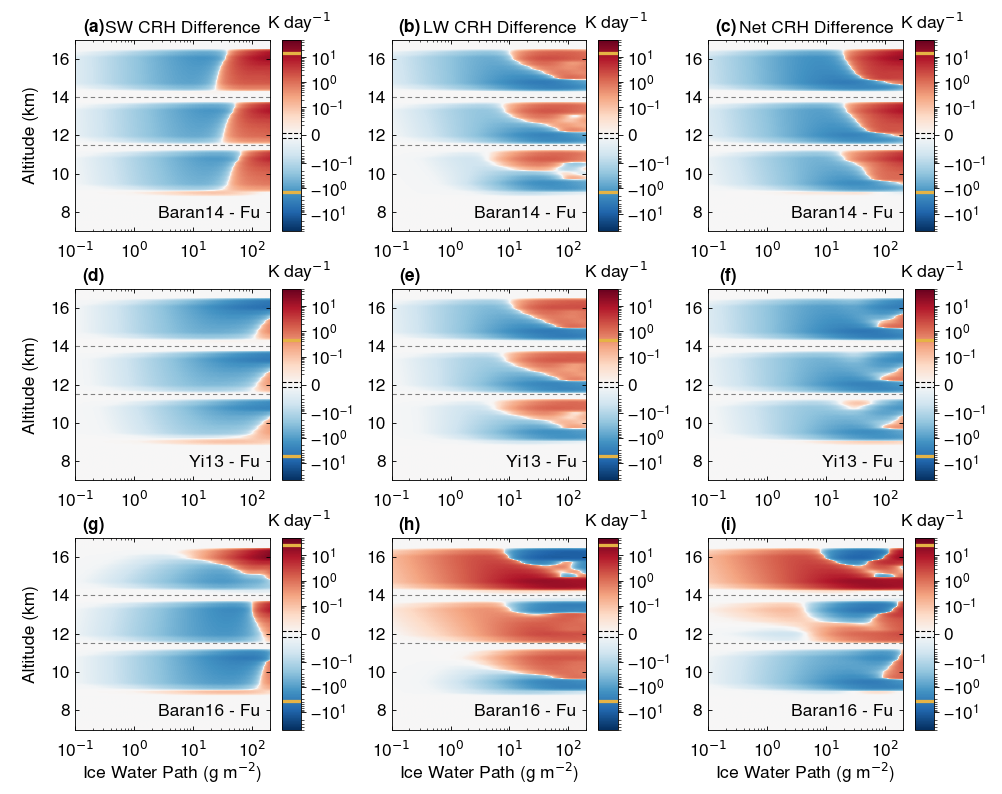

In [63]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 10.1 # inches
flength  = 12.75 # inches

rows    = 3
columns = 3
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
# plt.subplots_adjust(top = 0.95, bottom = 0.08, left = 0.075, right = 0.97, 
#                     hspace = .35, wspace = .3)
plt.subplots_adjust(top = 0.95, bottom = 0.08, left = 0.075, right = 0.95, 
                    hspace = .3, wspace = .3)

IntSch_order = [2, 0, 1] # Baran2014 - Fu, Yi - Fu and Baran2016 - Fu
labelpad     = -50

for diff in range(rows): 
    IntSch = IntSch_order[diff]

    
    # Shortwave Heating Rate Difference
    im = ax[diff, 0].imshow(H_sw_diff_plot[IntSch], cmap = "RdBu_r", aspect = 'auto',
                            norm = colors.SymLogNorm(linthresh, linscale, base = 10,
                                                     vmin = vmin, vmax = vmax)) 
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
    cbar.ax.axhline(sw_ranges[IntSch, 0], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(sw_ranges[IntSch, 1], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.ax.axhline(-linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.set_label(r'K day$^{-1}$', labelpad = labelpad, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.yaxis.set_ticks(maj_tickbar, major = True)
    cbar.ax.yaxis.set_ticks(min_tickbar, minor = True)
    cbar.ax.tick_params(labelsize = fontsize, which = 'major', length = 5)
    cbar.ax.tick_params(which = 'minor', length = 2.5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[diff, 0].set_title('SW CRH Difference', color = 'black', x = 0.555, y = 1,
                              fontsize = fontsize, fontname = fontname)

    # Longwave Heating Rate
    im = ax[diff, 1].imshow(H_lw_diff_plot[IntSch], cmap = "RdBu_r", aspect = 'auto', 
                            norm = colors.SymLogNorm(linthresh, linscale, base = 10,
                                                     vmin = vmin, vmax = vmax)) 
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
    cbar.ax.axhline(sw_ranges[IntSch, 0], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(sw_ranges[IntSch, 1], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.ax.axhline(-linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.set_label(r'K day$^{-1}$', labelpad = labelpad, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.yaxis.set_ticks(maj_tickbar, major = True)
    cbar.ax.yaxis.set_ticks(min_tickbar, minor = True)
    cbar.ax.tick_params(labelsize = fontsize, which = 'major', length = 5)
    cbar.ax.tick_params(which = 'minor', length = 2.5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[diff, 1].set_title('LW CRH Difference', color = 'black', x=0.555, y=1,
                              fontsize = fontsize, fontname = fontname)

    # Heating Rate
    im = ax[diff, 2].imshow(H_net_diff_plot[IntSch], cmap = "RdBu_r", aspect = 'auto',
                            norm = colors.SymLogNorm(linthresh, linscale, base = 10,
                                                     vmin = vmin, vmax = vmax)) 
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
    cbar.ax.axhline(sw_ranges[IntSch, 0], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(sw_ranges[IntSch, 1], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.ax.axhline(-linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.set_label(r'K day$^{-1}$', labelpad = labelpad, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.yaxis.set_ticks(maj_tickbar, major = True)
    cbar.ax.yaxis.set_ticks(min_tickbar, minor = True)
    cbar.ax.tick_params(labelsize = fontsize, which = 'major', length = 5)
    cbar.ax.tick_params(which = 'minor', length = 2.5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[diff, 2].set_title('Net CRH Difference', color ='black', x=0.555, y=1,
                              fontsize = fontsize, fontname = fontname)
        
    ax[IntSch, 0].axhline((height_hl_pd - 11.5).abs().argmin(),
                       dashes=[4, 3], color = 'grey', linewidth = 1)
    ax[IntSch, 0].axhline((height_hl_pd - 14).abs().argmin(),
                       dashes=[4, 3], color = 'grey', linewidth = 1)
    ax[IntSch, 1].axhline((height_hl_pd - 11.5).abs().argmin(),
                       dashes=[4, 3], color = 'grey', linewidth = 1)
    ax[IntSch, 1].axhline((height_hl_pd - 14).abs().argmin(), 
                       dashes=[4, 3], color = 'grey', linewidth = 1)
    ax[IntSch, 2].axhline((height_hl_pd - 11.5).abs().argmin(),
                       dashes=[4, 3], color = 'grey', linewidth = 1)
    ax[IntSch, 2].axhline((height_hl_pd - 14).abs().argmin(), 
                       dashes=[4, 3], color = 'grey', linewidth = 1)

        
# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0, H_net_236.shape[2]+1, 8) # altitude tick labels
# height tickLabels are rounded for visualization:
yticklabels = (height_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()
    
# X Axis: # Logscale ticklabels are built manually:
major_xticklabels = np.logspace(np.log10(0.1), np.log10(100), 4)
minor_xticklabels = list(np.linspace(0.1, 1, 10))[:-1] + list(np.linspace(1, 10, 10))[:-1] + list(np.linspace(10, 100, 10)) + [200]
major_xticks      = []
minor_xticks      = []
for xticklabelsi in major_xticklabels:
    major_xticks.append(np.where(iwp == min(iwp, key = lambda x: abs(x - xticklabelsi)))[0][0])
for xticklabelsi in minor_xticklabels:
    minor_xticks.append(np.where(iwp == min(iwp, key = lambda x: abs(x - xticklabelsi)))[0][0])
    
Diff_sw         = ['Yi13 - Fu', 'Baran16 - Fu', 'Baran14 - Fu']
Diff_lw         = ['Yi13 - Fu', 'Baran16 - Fu', 'Baran14 - Fu']
Diff            = ['Yi13 - Fu', 'Baran16 - Fu', 'Baran14 - Fu']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)']
panel_letters_i = 0
for diff in range(rows):
    IntSch = IntSch_order[diff]
    for j in range(columns):
        if diff == 2:
            ax[diff, j].set_xlabel(r'Ice Water Path (g m$^{-2}$)', 
                                   fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 0)
        ax[diff, j].set_xticks(major_xticks)
        ax[diff, j].set_xticks(minor_xticks, minor = True)
        ax[diff, j].tick_params(axis = 'x', which = 'major', color = 'black',
                               size = 4, direction = 'in', top = True,
                               labelsize = fontsize, pad = 10)
        ax[diff, j].tick_params(axis = 'x', which = 'minor', color = 'black',
                               size = 2, direction = 'in', top = True,
                               labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_xticklabels():
            tick.set_fontname(fontname)   
        #ax[diff, j].set_xticks(xticks)
        ax[diff, j].set_xticklabels(major_xticklabels)
        ax[diff, j].set_xticklabels([r'10$^{-1}$', r'10$^{0}$', r'10$^{1}$', r'10$^{2}$'])
        #ax[diff, j].set_xlim(0.1, 2000)
        #ax[diff, j].set_xscale('log')
        
        ax[diff, j].tick_params(axis = 'y', which = 'major', color = 'black',
                                size = 4, direction = 'in', right = True,
                                labelsize = fontsize, pad = 5)
        for tick in ax[diff, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_yticks(yticks)
        ax[diff, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[diff, j].set_ylabel('Altitude (km)', fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 10)
            ax[diff, j].text(0.95, 0.05, Diff_sw[IntSch],
                             ha = 'right', va = 'bottom', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 1:
            ax[diff, j].text(0.95, 0.05, Diff_lw[IntSch],
                             ha = 'right', va = 'bottom', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 2:
            ax[diff, j].text(0.95, 0.05, Diff[IntSch],
                             ha = 'right', va = 'bottom', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        ax[diff, j].set_ylim((height_hl_pd - 7).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        # Panel letters:
        ax[diff, j].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
                         ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                         fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/1D_ecrad_analysis/paper_figures/')
plt.savefig(out_dir+'crh_diff_test3_Fu_F5_v6alt.pdf', dpi=500)